In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from explainers_lib.explainers.native.growing_spheres import GrowingSpheresExplainer
from explainers_lib.model import Model as ExplainerModel
import explainers_lib.model
from explainers_lib.datasets import Dataset

from explainers_lib.explainers.native.wachter import WachterExplainer
from explainers_lib.explainers.native.face import FaceExplainer as NativeFaceExplainer
from explainers_lib.explainers.native.growing_spheres import GrowingSpheresExplainer

from explainers_lib.explainers.celery_explainer import ActionableRecourseExplainer
from explainers_lib.explainers.celery_explainer import FaceExplainer
from explainers_lib.explainers.celery_explainer import DiceExplainer
from explainers_lib.explainers.celery_explainer import AlibiCFProto
from explainers_lib.explainers.celery_explainer import AlibiCFRL

from explainers_lib.aggregators import Pareto, All
from explainers_lib.datasets import Dataset
from explainers_lib.ensemble import Ensemble


/home/berni/education/counterfactuals/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:
# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)


Path to dataset files: /home/berni/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [4]:
root = path
img_dir = root + "/img_align_celeba/img_align_celeba"
attr_path = os.path.join(root, "list_attr_celeba.csv")


df = pd.read_csv(attr_path)
df = df.rename(columns=lambda s: s.strip())

# Convert to numeric labels
df["Young"] = df["Young"].apply(lambda x: 1 if x == 1 else 0)
df["Smiling"] = df["Smiling"].apply(lambda x: 1 if x == 1 else 0)

df["class"] = (
    df["Young"] * 2 + df["Smiling"]
)  # creates 0–3 target class

# Keep only first 11k (10k train + 1k test)
# df = df.iloc[:11000]

train_df, test_df = train_test_split(df, test_size=1000, shuffle=True, random_state=42)

train_df, val_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=42)

transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize((0.5,)*3, (0.5,)*3)   # images mapped to [-1, 1]
])

class Celeb4ClassDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(row["class"], dtype=torch.long)
        return img, label

train_ds = Celeb4ClassDataset(train_df, img_dir, transform)
val_ds = Celeb4ClassDataset(val_df, img_dir, transform)
test_ds = Celeb4ClassDataset(test_df, img_dir, transform)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)


In [5]:

class_map = {
    0: "old no smile",
    1: "old smile",
    2: "young no smile",
    3: "young smile"
}


In [6]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.block(x)

class TransConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(3,   32),   # 128 -> 64
            ConvBlock(32,  64),   # 64 -> 32
            ConvBlock(64,  128),  # 32 -> 16
            ConvBlock(128, 256),  # 16 -> 8
            ConvBlock(256, 512),  # 8 -> 4
            ConvBlock(512, 512),  # 4 -> 2
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, latent_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.encoder(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512 * 2 * 2),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            TransConvBlock(512, 512),   # 2 → 4
            TransConvBlock(512, 512),   # 4 → 8
            TransConvBlock(512, 256),   # 8 → 16
            TransConvBlock(256, 128),   # 16 → 32
            TransConvBlock(128, 64),    # 32 → 64
            TransConvBlock(64, 32),     # 64 → 128
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 2, 2)
        x = self.decoder(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = Encoder(latent_dim).to(device)
        self.decoder = Decoder(latent_dim).to(device)

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        flatten_dim = 32 * 32 * 32

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [8]:
import torch
import torch.nn as nn

# This class replaces BatchedLatentWrapper's architecture logic
class LatentToClassPipeline(nn.Module):
    def __init__(self, decoder, cnn):
        super().__init__()
        self.decoder = decoder
        self.cnn = cnn

    def forward(self, x):
        # 1. Decode
        decoded = self.decoder(x)
        # 2. Scale (Your custom logic)
        decoded = decoded * 0.5 
        # 3. Classify
        logits = self.cnn(decoded)
        return logits


In [9]:
import torch

autoencoder = Autoencoder(latent_dim=128).to(device)

weights = torch.load("autoencoder_celeba_best.pth", map_location=device)

autoencoder.load_state_dict(weights)

autoencoder.eval()


Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ConvBlock(
        (block): Sequential(
          (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): ConvBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): ConvBlock(
        (block): Sequential(
          (0): C

In [10]:
cnn = CNN().to(device)
cnn_weights = torch.load("models/torch_cnn_celeba_paper.pth", map_location=device)
cnn.load_state_dict(cnn_weights)
cnn.eval()


CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [11]:
from explainers_lib.model import TorchModel

# latent_wrapper = TorchModel(BatchedLatentWrapper(autoencoder.decoder, cnn, device))


In [12]:
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder


n_samples = 10

batch = next(iter(train_dl))
images_batch, labels_batch = batch
imgs = images_batch[:n_samples].to(device)
targets = labels_batch[:n_samples].cpu().tolist()

with torch.no_grad():
    latent_tensors = autoencoder.encoder(imgs)

latent_instance_np = latent_tensors.cpu().detach().numpy()
latent_dim_actual = latent_instance_np.shape[1]
feature_names = [f'l{i}' for i in range(latent_dim_actual)]

data_df = pd.DataFrame(latent_instance_np, columns=feature_names)

identity = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', feature_names),
        ("cat", OneHotEncoder(), []),

    ],    remainder='drop'
)
identity.fit(data_df)


latent_dataset_train = Dataset(
    df=data_df,
    target=targets,
    features=feature_names,
    categorical_features=[],
    continuous_features=feature_names,
    immutable_features=[],
    allowable_ranges={},
    preprocessor=identity
)


In [13]:
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder


n_samples = 10

batch = next(iter(test_dl))
images_batch, labels_batch = batch
imgs = images_batch[:n_samples].to(device)
targets = labels_batch[:n_samples].cpu().tolist()

with torch.no_grad():
    latent_tensors = autoencoder.encoder(imgs)

latent_instance_np = latent_tensors.cpu().detach().numpy()
latent_dim_actual = latent_instance_np.shape[1]
feature_names = [f'l{i}' for i in range(latent_dim_actual)]

data_df = pd.DataFrame(latent_instance_np, columns=feature_names)

identity = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', feature_names),
        ("cat", OneHotEncoder(), []),
    ],    remainder='drop'
)

identity.fit(data_df)

# transformer = 

latent_dataset = Dataset(
    df=data_df,
    target=targets,
    # features=feature_names,
    categorical_features=[],
    continuous_features=feature_names,
    immutable_features=[],
    allowable_ranges={},
    preprocessor=identity
)


In [14]:
# 1. Instantiate your pipeline
pipeline = LatentToClassPipeline(autoencoder.decoder, cnn).to(device)
# pipeline.eval() 

# 1. Move the pipeline to CPU explicitly
#    (This changes all weights to be CPU tensors)
pipeline = pipeline.to("cpu")
pipeline.eval()

# 2. Re-create the TorchScript on the CPU
#    Now the script will only contain CPU instructions.
scripted_model = torch.jit.script(pipeline)
scripted_model.to(device).eval()

# 3. Wrap it in TorchModel
#    (Ensure you imported TorchModel from explainers_lib.model)
new_torch_model = TorchModel(scripted_model)

from explainers_lib.explainers.dice.dice import DiceExplainer

ensemble = Ensemble(
    new_torch_model,
    [
        # Native
        # WachterExplainer(lambda_param=500),
        GrowingSpheresExplainer(step_size=0.1, num_samples=5, max_radius=3),
        # NativeFaceExplainer(),
        # # Carla
        # # TODO(patryk): currently broken, but I am working on it! 
        # # ActionableRecourseExplainer(),
        # # Dice
        # DiceExplainer(method="random", desired_class=2),
        # # Alibi
        # AlibiCFProto(),
        # AlibiCFRL()
    ],
    All())


# 4. Update the ensemble
# ensemble.model = new_torch_model
ensemble.fit(latent_dataset_train)
print("Ensemble fitted.")
# 5. Run the explanation
cfes = ensemble.explain(latent_dataset)


Ensemble fitted.


10instance [00:09,  1.06instance/s]


In [15]:
cfes


[Counterfactual(original_data=array([-0.23730542,  0.04897172, -0.30847168,  0.05188293,  0.34749568,
         0.16788326, -0.4138526 ,  0.11078232, -0.10901439,  0.19289513,
        -0.1740379 , -0.16783322,  0.08702274, -0.13146384, -0.06250711,
        -0.28603023,  0.20314854, -0.02043954,  0.37624428,  0.26104528,
        -0.05817656, -0.19977939,  0.04384131, -0.19655581, -0.05008828,
        -0.10946906,  0.36538306, -0.12172448, -0.24142498,  0.311403  ,
        -0.19205227,  0.01188338,  0.1254392 , -0.28921455,  0.02295408,
         0.14733726, -0.22760722, -0.09190615, -0.19484311,  0.03714231,
        -0.17059931, -0.07802055,  0.29851595,  0.19042398, -0.4423178 ,
        -0.30820495, -0.02872369, -0.3380597 , -0.1824288 ,  0.02972568,
        -0.1741253 ,  0.27573562,  0.07428034,  0.11732936, -0.01339039,
         0.06545938,  0.05894195,  0.19272329,  0.42291382, -0.09762926,
         0.03802542,  0.06616586, -0.00674141, -0.00639369, -0.02939689,
        -0.16770738, -

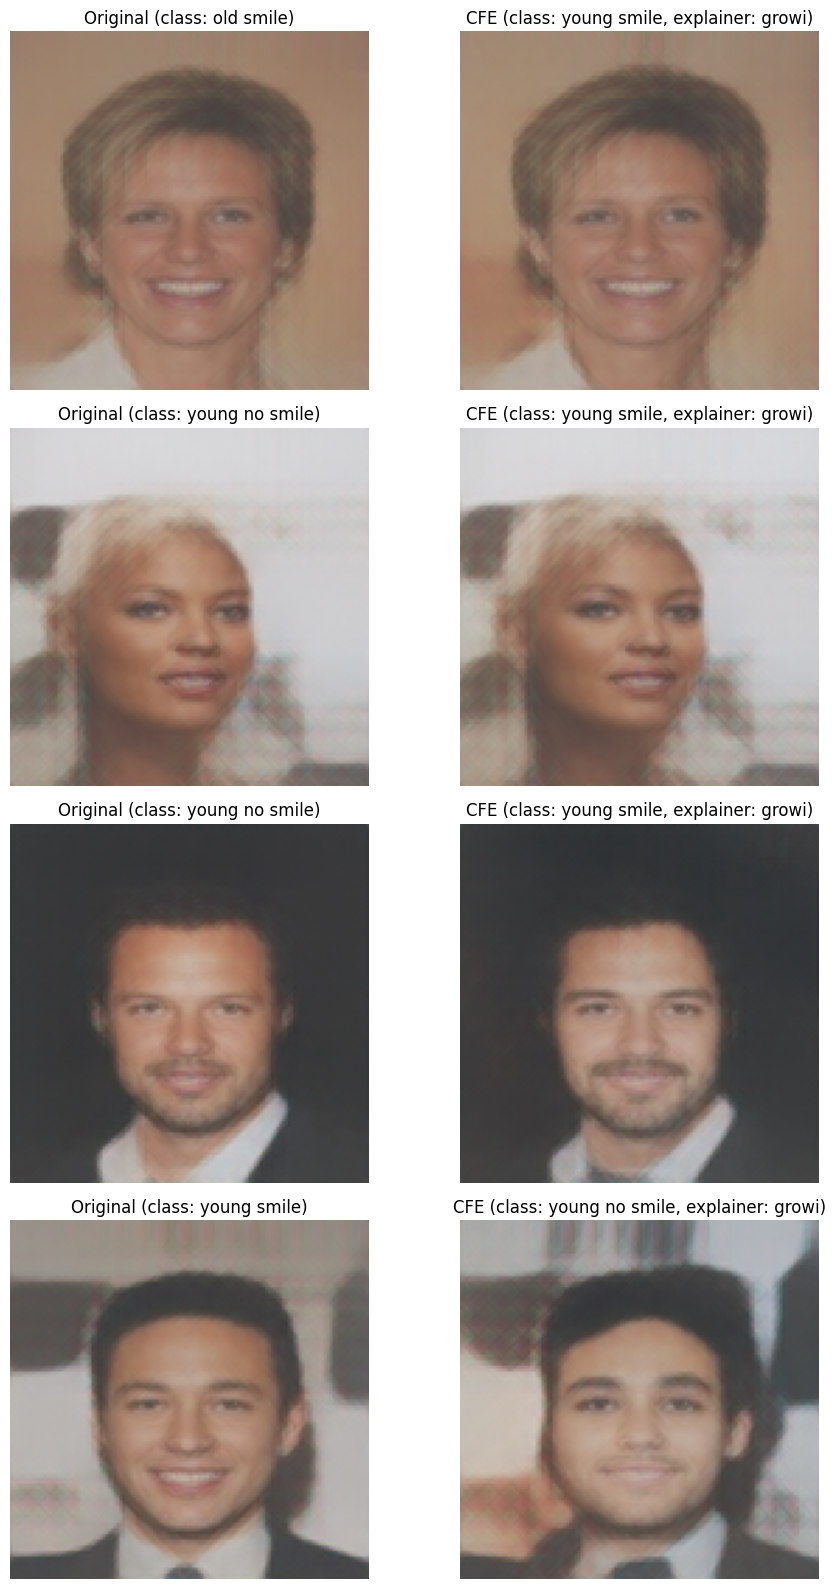

In [16]:
n = len(cfes)
plt.figure(figsize=(10, 4 * n))
autoencoder.to(device)
autoencoder.eval()

for i in range(n):
    cf = cfes[i]

    # ---- ORIGINAL RECONSTRUCTION ----
    org_latent = torch.tensor(cf.original_data, dtype=torch.float32, device=device).unsqueeze(0)
    org_recon = autoencoder.decoder(org_latent)      # shape [1, 3, 128, 128]

    org_recon_np = org_recon.detach().cpu().permute(0, 2, 3, 1).numpy()[0]

    # map from [-1, 1] → [0, 1]
    org_recon_np = (org_recon_np + 1) / 2
    org_recon_np = org_recon_np.clip(0, 1)

    # ---- COUNTERFACTUAL RECONSTRUCTION ----
    cf_latent = torch.tensor(cf.data, dtype=torch.float32, device=device).unsqueeze(0)
    cfe_recon = autoencoder.decoder(cf_latent)

    cfe_recon_np = cfe_recon.detach().cpu().permute(0, 2, 3, 1).numpy()[0]
    cfe_recon_np = (cfe_recon_np + 1) / 2
    cfe_recon_np = cfe_recon_np.clip(0, 1)

    # ---- PLOTTING ----
    plt.subplot(n, 2, 2 * i + 1)
    plt.imshow(org_recon_np)
    plt.title(f"Original (class: {class_map[cf.original_class]})")
    plt.axis("off")

    plt.subplot(n, 2, 2 * i + 2)
    plt.imshow(cfe_recon_np)
    plt.title(f"CFE (class: {class_map[cf.target_class]}, explainer: {cf.explainer[:5]})")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [17]:
import numpy as np

for i, cf in enumerate(cfes):
    # 1. Check Numeric Difference in Latent Space
    diff = np.abs(cf.original_data - cf.data).sum()
    dist = np.linalg.norm(cf.original_data - cf.data)
    
    print(f"--- CF {i} ---")
    print(f"Original Class: {cf.original_class}")
    print(f"Target Class:   {cf.target_class}")
    print(f"Difference (L1): {diff:.5f}")
    print(f"Distance (L2):   {dist:.5f}")
    
    # 2. Check if the model actually predicts the target class
    # (Pass the counterfactual latent back to your pipeline)
    # We need to reshape it to match what the model expects (usually [1, latent_dim])
    cf_tensor = torch.tensor(cf.data, dtype=torch.float32, device=device).unsqueeze(0)
    
    with torch.no_grad():
        # Get raw logits from your pipeline
        logits = scripted_model(cf_tensor) 
        pred_idx = torch.argmax(logits, dim=1).item()
        
    print(f"Model Prediction for CF: {pred_idx} (Target was {cf.target_class})")
    
    if pred_idx == cf.target_class and dist < 1e-3:
        print("RESULT: This is an ADVERSARIAL EXAMPLE (Invisible change, but label flipped).")
    elif diff == 0:
        print("RESULT: The explainer FAILED to find a solution (Returned original).")
    else:
        print("RESULT: Distinct image generated.")
    print("-" * 30)


--- CF 0 ---
Original Class: 1
Target Class:   3
Difference (L1): 5.24236
Distance (L2):   0.57310
Model Prediction for CF: 3 (Target was 3)
RESULT: Distinct image generated.
------------------------------
--- CF 1 ---
Original Class: 2
Target Class:   3
Difference (L1): 5.22904
Distance (L2):   0.56366
Model Prediction for CF: 3 (Target was 3)
RESULT: Distinct image generated.
------------------------------
--- CF 2 ---
Original Class: 2
Target Class:   3
Difference (L1): 15.39689
Distance (L2):   1.71517
Model Prediction for CF: 3 (Target was 3)
RESULT: Distinct image generated.
------------------------------
--- CF 3 ---
Original Class: 3
Target Class:   2
Difference (L1): 20.74191
Distance (L2):   2.24076
Model Prediction for CF: 2 (Target was 2)
RESULT: Distinct image generated.
------------------------------
